# Lab 5 - R Code

Authors: Valerie Dube, Erzo Garay, Juan Marcos Guerrero y Matias Villalba

## Replication and Data analysis

In [1]:
library(hdm)
library(xtable)
library(randomForest)
library(glmnet)
library(sandwich)
library(rpart)
library(nnet)
library(gbm)
library(rpart.plot)
library(keras)
library(xtable)
library(glmnet)
library(randomForest)
library(ggplot2)

randomForest 4.7-1.1



Type rfNews() to see new features/changes/bug fixes.



Loading required package: Matrix



Loaded glmnet 4.1-8



Loaded gbm 2.2.2



This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3




Attaching package: 'ggplot2'




The following object is masked from 'package:randomForest':

    margin




In [2]:
set.seed(1)
rm(list = ls())

In [3]:
library(ggplot2)
library(WeightIt)
library(cobalt)

 cobalt (Version 4.5.5, Build Date: 2024-04-02)



### 1. Descriptives

#### 1.1. Descriptive table (vale)

In [4]:
# Import data and see first observations
data = read.csv("../../data/processed_esti.csv")
head(data)

,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
2,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
3,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
4,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
5,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3
6,1,1,0,1,0,0,0,0,0,1,0,1,0,24,2


In [5]:
str(data)

'data.frame':	1739 obs. of  15 variables:
 $ y                       : int  1 0 0 0 1 1 1 0 0 1 ...
 $ w                       : int  1 0 1 0 1 1 1 0 1 1 ...
 $ gender_female           : int  0 0 0 1 1 0 1 0 0 1 ...
 $ gender_male             : int  1 1 1 0 0 1 0 1 1 0 ...
 $ gender_transgender      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ethnicgrp_asian         : int  0 0 0 0 1 0 0 0 0 0 ...
 $ ethnicgrp_black         : int  0 0 1 0 0 0 0 1 0 1 ...
 $ ethnicgrp_mixed_multiple: int  1 0 0 0 0 0 0 0 0 0 ...
 $ ethnicgrp_other         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ethnicgrp_white         : int  0 1 0 1 0 1 1 0 1 0 ...
 $ partners1               : int  0 0 0 1 0 0 0 0 1 0 ...
 $ postlaunch              : int  1 0 1 0 1 1 0 1 0 0 ...
 $ msm                     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ age                     : int  27 19 26 20 24 24 24 21 27 21 ...
 $ imd_decile              : int  5 6 4 2 3 2 4 2 2 6 ...


In [6]:
by(data[, !names(data) %in% 'y'], data$w, summary)

data$w: 0
       w     gender_female     gender_male     gender_transgender
 Min.   :0   Min.   :0.0000   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:0   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.000000  
 Median :0   Median :1.0000   Median :0.0000   Median :0.000000  
 Mean   :0   Mean   :0.5807   Mean   :0.4181   Mean   :0.001223  
 3rd Qu.:0   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :0   Max.   :1.0000   Max.   :1.0000   Max.   :1.000000  
 ethnicgrp_asian   ethnicgrp_black   ethnicgrp_mixed_multiple ethnicgrp_other  
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000          Min.   :0.00000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.00000          1st Qu.:0.00000  
 Median :0.00000   Median :0.00000   Median :0.00000          Median :0.00000  
 Mean   :0.05501   Mean   :0.09291   Mean   :0.09291          Mean   :0.01711  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.00000          3rd Qu.:0.00000  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.0

The observations for each variable are generally balanced between the control and treatment groups. Additionally, most participants are white, with an average age of approximately 23. The mean IMD decile scores are around 3.5, indicating that participants in both groups tend to come from more deprived areas.

#### 1.2. Descriptive graphs (vale)

In [7]:
#Generating propensity score weights for the ATT
w.out <- WeightIt::weightit(w ~ age + gender_male + ethnicgrp_white + partners1 + imd_decile,
                            data = data,
                            method = "glm",
                            estimand = "ATT")

bal.tab(w.out)

Balance Measures
                    Type Diff.Adj
prop.score      Distance  -0.0025
age              Contin.  -0.0009
gender_male       Binary   0.0004
ethnicgrp_white   Binary  -0.0001
partners1         Binary  -0.0010
imd_decile       Contin.   0.0021

Effective sample sizes
           Control Treated
Unadjusted  818.       921
Adjusted    815.66     921

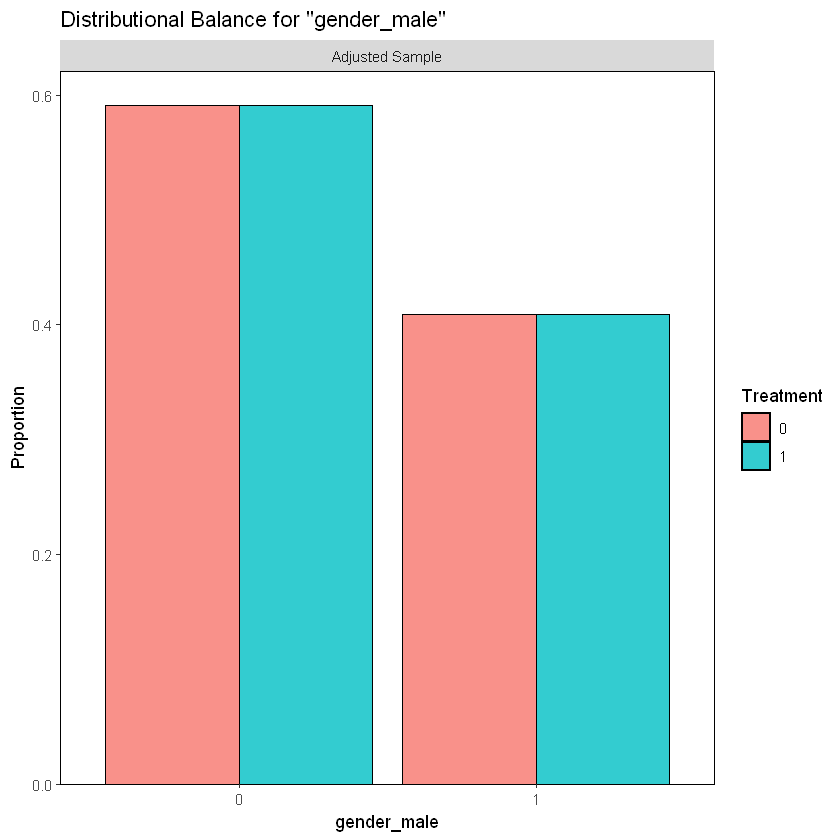

In [8]:
bal.plot(w.out, var.name = "gender_male")

As we saw in section 1.1., there is a similar percentage of males and females participants in each treatment group in the sample. 

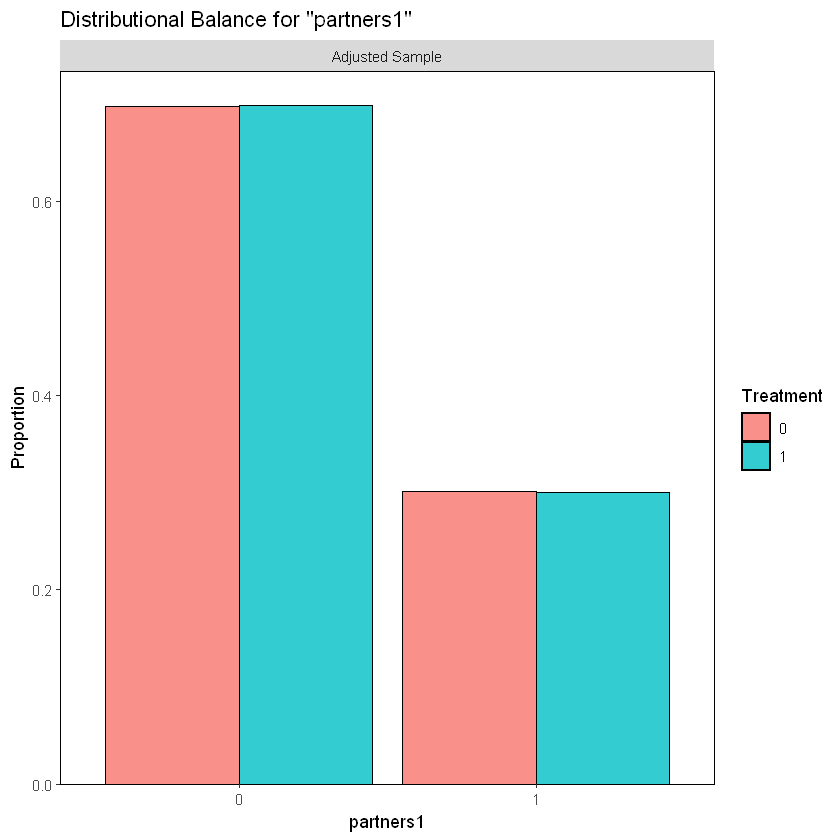

In [9]:
bal.plot(w.out, var.name = "partners1")

In a similar manner, we note an equal percentage of participants with 2 or more sexual partners as well as those with 1 sexual partner in the last 12 months from the beginning of the study, per treatment or control group.

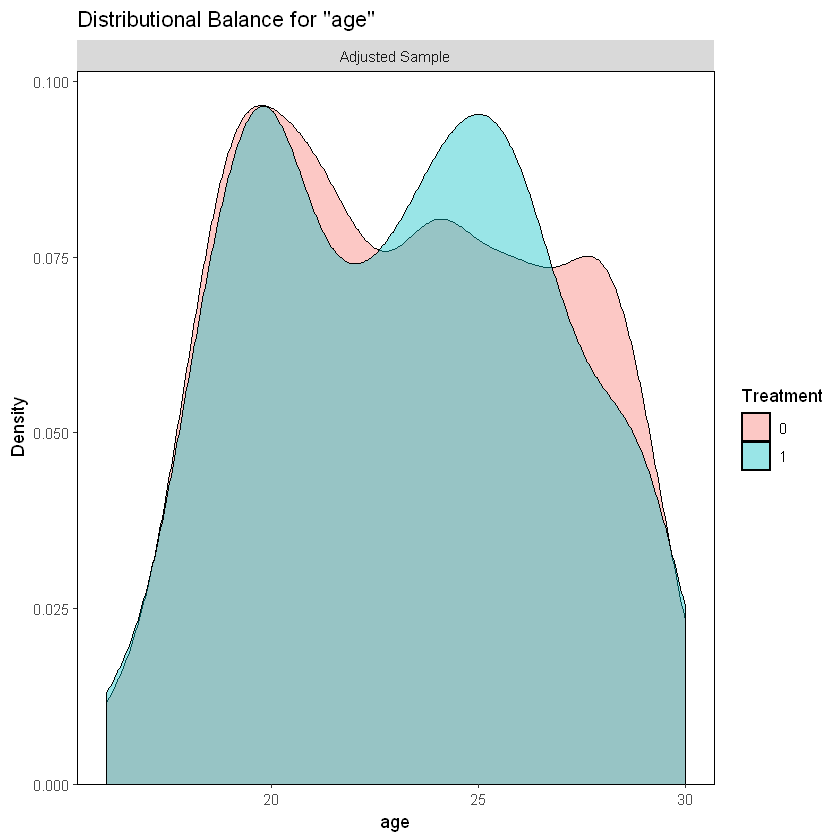

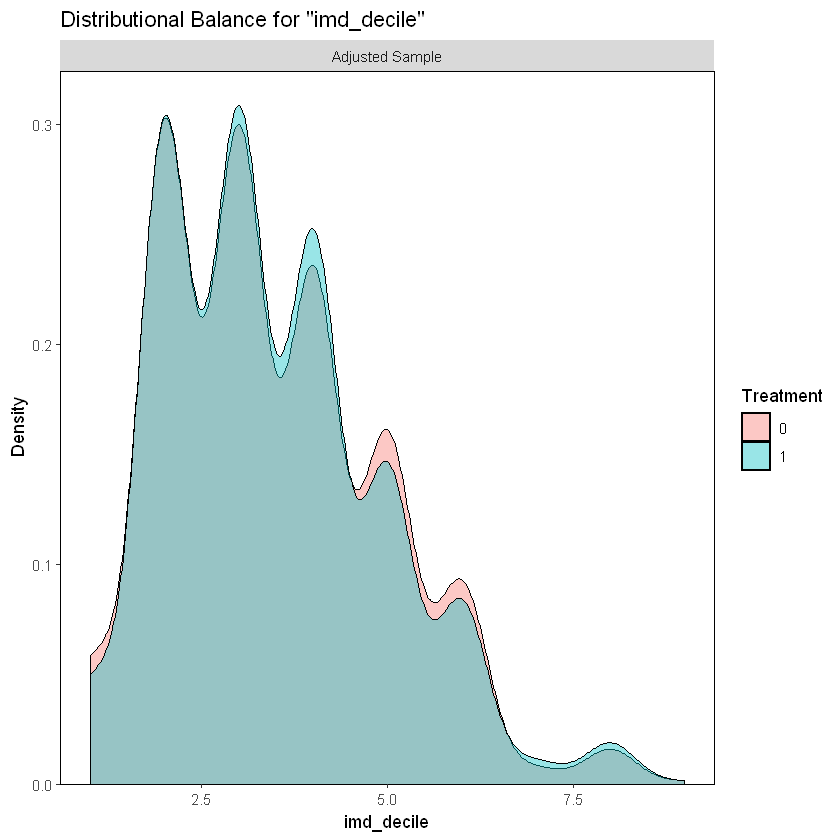

In [10]:
bal.plot(w.out, var.name = "age")
bal.plot(w.out, var.name = "imd_decile")

We can see a higher percentage of participants aged between 23 and 27 in the treatment group. Also, there is a higher perceptange of participants aged between 21 and 22 and 27 and 29 in the control group.

In the case of the IMD decile, an index that measures poverty in the UK, we can see the same proportion of participants in each group.

### 2. Linear Regression analysis

#### 2.1. Regression 1: $y = \beta_0 + \beta_1 T + \epsilon$   (Vale)

In [11]:
lm(formula = y ~ w, data = data)


Call:
lm(formula = y ~ w, data = data)

Coefficients:
(Intercept)            w  
     0.2115       0.2652  


We found that the adjusted R-squared is 0.076 and the ATE is approximately 0.27. This means that the treatment explains only 7.6% of the increase in the STI tests between the control and treatment groups. Additionally, receiving the treatment (i.e. being invited to use the internet-based sexual health service) increases, on average, the probability of taking an STI test by 26.5%.

#### 2.2. Regression 2: $y = \beta_0 + \beta_1 T + \beta_2 X + \epsilon$  (vale)

In [12]:
lm(formula = y ~ w + age + gender_female + ethnicgrp_white + ethnicgrp_black + ethnicgrp_mixed_multiple + partners1 + postlaunch + imd_decile + msm, data = data)


Call:
lm(formula = y ~ w + age + gender_female + ethnicgrp_white + 
    ethnicgrp_black + ethnicgrp_mixed_multiple + partners1 + 
    postlaunch + imd_decile + msm, data = data)

Coefficients:
             (Intercept)                         w                       age  
               -0.162682                  0.255716                  0.012476  
           gender_female           ethnicgrp_white           ethnicgrp_black  
                0.091026                  0.049819                 -0.040238  
ethnicgrp_mixed_multiple                 partners1                postlaunch  
               -0.035933                 -0.059428                  0.077319  
              imd_decile                       msm  
               -0.004155                 -0.006273  


Compared to the previous regression, when we include additional variables (age, gender, ethnic group, number of sexual partners, the indicator for Randomised after SH:24 made publicly available, the indicator for men who have sex with men, and the socioeconomic level measured by deciles), we observe an increase in the adjusted R-squared of approximately 0.3 percentage points (from 0.1). Additionally, the ATE decreases by 0.003 percentage points, indicating a negative bias.

It is worth mentioning that we omit gender_male to avoid collinearity with gender_female. Similarly, we exclude the less relevant ethnic group (i.e. the one with fewer observations) to prevent the same issue.

#### 2.3.

We observe that the ATE using double lasso is akin to the OLS with confounders, along with the adjusted R-squared.

#### 2.4.

In general, the three ATEs are very similar, but we consider that the models that include the cofounders (OLS with controls and DL) are better estimated.

### 3. Non-Linear Methods DML

In [13]:
rm(list=ls())
DML <- as.data.frame(read.table("../../../data/processed_esti.csv", header=T ,sep=","))
#DML <- as.data.frame(read.table("C:/Users/Erzo/Documents/GitHub/CausalAI-Course/data/processed_esti.csv", header=T ,sep=","))

set.seed(1234)
training <- sample(nrow(DML), nrow(DML)*(3/4), replace=FALSE)
data_train <- DML[training,]
data_test <- DML[-training,]
Y_test <- data_test$y

y = as.matrix(data_train[,1])         # outcome: growth rate
d = as.matrix(data_train[,2])         # treatment: initial wealth
x = as.matrix(data_train[,-c(1,2)]) # controls: country characteristics

Warning message in file(file, "rt"):
"cannot open file '../../../data/processed_esti.csv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


### DML function for Regression tree

In [9]:
DML2.for.PLM.tree <- function(data_train, dreg, yreg, nfold=10) {
  nobs <- nrow(data_train) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    datitanow=data_train[-I[[b]],-c(2)]
    datitanoy=data_train[-I[[b]],-c(1)]
    datitanowpredict=data_train[I[[b]],-c(2)]
    datitanoypredict=data_train[I[[b]],-c(1)]
    
    dfit <- dreg(datitanoy) #take a fold out
    yfit <- yreg(datitanow) # take a foldt out
    dhat <- predict(dfit, datitanoypredict ) #predict the left-out fold
    yhat <- predict(yfit, datitanowpredict ) #predict the left-out fold
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
  }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil) ) #save output and residuals
}

### DML function for Boosting Trees

In [10]:
DML2.for.PLM.boosttree <- function(data_train, dreg, yreg, nfold=10) {
  nobs <- nrow(data_train) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    datitanow=data_train[-I[[b]],-c(2)]
    datitanoy=data_train[-I[[b]],-c(1)]
    datitanowpredict=data_train[I[[b]],-c(2)]
    datitanoypredict=data_train[I[[b]],-c(1)]
    
    dfit <- dreg(datitanoy) #take a fold out
    best.boostt  <- gbm.perf(dfit, plot.it = FALSE) # cross-validation to determine when to stop
    yfit <- yreg(datitanow) # take a foldt out
    best.boosty  <- gbm.perf(yfit, plot.it = FALSE) # cross-validation to determine when to stop
    dhat <- predict(dfit, datitanoypredict, n.trees=best.boostt) 
    yhat <- predict(yfit, datitanowpredict, n.trees=best.boosty) #predict the left-out fold
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
  }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil) ) #save output and residuals
}

### DML function for Lasso and Random Forest

In [11]:
DML2.for.PLM <- function(x, d, y, dreg, yreg, nfold=10) {
  nobs <- nrow(x) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(x[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(x[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, x[I[[b]],], type="response") #predict the left-out fold
    yhat <- predict(yfit, x[I[[b]],], type="response") #predict the left-out fold
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
  }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil) ) #save output and residuals
}

#### 3.1. Lasso

In [17]:
cat(sprintf("\nDML with Lasso \n"))
dreg_lasso <- function(x,d){ rlasso(x,d, post=FALSE) } #ML method= lasso from hdm
yreg_lasso <- function(x,y){ rlasso(x,y, post=FALSE) } #ML method = lasso from hdm
DML2.lasso = DML2.for.PLM(x, d, y, dreg_lasso, yreg_lasso, nfold=10)

coef_lasso<-as.numeric(DML2.lasso$coef.est)
se_lasso<-as.numeric(DML2.lasso$se)
prRes_lassoD<- c(mean((DML2.lasso$dtil)^2));
prRes_lassoY<- c(mean((DML2.lasso$ytil)^2));
prRes_lasso<- rbind(coef_lasso,se_lasso,sqrt(prRes_lassoD), sqrt(prRes_lassoY));
rownames(prRes_lasso)<- c("Estimate","Standard Error","RMSE D", "RMSE Y");
colnames(prRes_lasso)<- c("Lasso")
prRes_lasso 


DML with Lasso 
fold: 

ERROR: Error in rlasso(x, d, post = FALSE): no se pudo encontrar la función "rlasso"


The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 25.13 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.2. Regression Trees

In [ ]:
# Tree
X_basic <-  "gender_transgender + ethnicgrp_asian + ethnicgrp_black + ethnicgrp_mixed_multiple+ ethnicgrp_other + ethnicgrp_white + partners1 + postlaunch + msm + age+ imd_decile"
y_form_tree <- as.formula(paste("y", "~", X_basic))
t_form_tree <- as.formula(paste("w", "~", X_basic))
yreg_tree <- function(dataa){rpart(y_form_tree, dataa, minbucket=5, cp = 0.001)}
treg_tree <- function(dataa){rpart(t_form_tree, dataa, minbucket=5, cp = 0.001)}
DML2.tree = DML2.for.PLM.tree(data_train, treg_tree, yreg_tree, nfold=10)

coef_tree<-as.numeric(DML2.tree$coef.est)
se_tree<-as.numeric(DML2.tree$se)
prRes_treeD<- c(mean((DML2.tree$dtil)^2));
prRes_treeY<- c(mean((DML2.tree$ytil)^2));
prRes_tree<- rbind(coef_tree,se_tree,sqrt(prRes_treeD), sqrt(prRes_treeY));
rownames(prRes_tree)<- c("Estimate","Standard Error","RMSE D", "RMSE Y");
colnames(prRes_tree)<- c("Regression Tree")
prRes_tree 

The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 23.08 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.3. Boosting Trees

In [ ]:
yreg_treeboost<- function(dataa){gbm(y_form_tree, data=dataa, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)}
treg_treeboost<- function(dataa){gbm(t_form_tree, data=dataa, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)}
DML2.boosttree = DML2.for.PLM.boosttree(data_train, treg_treeboost, yreg_treeboost, nfold=10)

coef_boosttree<-as.numeric(DML2.boosttree$coef.est)
se_boosttree<-as.numeric(DML2.boosttree$se)
prRes_boosttreeD<- c(mean((DML2.boosttree$dtil)^2));
prRes_boosttreeY<- c(mean((DML2.boosttree$ytil)^2));
prRes_boosttree<- rbind(coef_boosttree,se_boosttree,sqrt(prRes_boosttreeD), sqrt(prRes_boosttreeY));
rownames(prRes_boosttree)<- c("Estimate","Standard Error","RMSE D", "RMSE Y");
colnames(prRes_boosttree)<- c("Regression Tree")
prRes_boosttree 

The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 25.28 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.4. Random Forest

In [ ]:
cat(sprintf("\nDML with Random Forest \n"))
dreg <- function(x,d){ randomForest(x, d) } #ML method=Forest
yreg <- function(x,y){ randomForest(x, y) } #ML method=Forest
DML2.RF = DML2.for.PLM(x, d, y, dreg, yreg, nfold=10)

coef_RF<-as.numeric(DML2.RF$coef.est)
se_RF<-as.numeric(DML2.RF$se)
prRes_RFD<- c(mean((DML2.RF$dtil)^2));
prRes_RFY<- c(mean((DML2.RF$ytil)^2));
prRes_RF<- rbind(coef_RF,se_RF,sqrt(prRes_RFD), sqrt(prRes_RFY));
rownames(prRes_RF)<- c("Estimate","Standard Error","RMSE D", "RMSE Y");
colnames(prRes_RF)<- c("Random Forest")
prRes_RF 

The message treatment providing information about Internet-accessed sexually transmitted 
infection testing predicts an increase in the probability that a person will get tested 
by 24.14 percentage points compared to receiving information about nearby clinics offering 
in-person testing. 
By providing both groups with information about testing, we mitigate the potential reminder 
effect, as both groups are equally prompted to consider testing. This approach allows us to 
isolate the impact of the type of information "Internet-accessed testing" versus "in-person clinic 
testing" on the likelihood of getting tested. Through randomized assignment, we establish causality 
rather than mere correlation, confirming that the intervention's effect is driven by the unique 
advantages of Internet-accessed testing, such as increased privacy, reduced embarrassment, and 
convenience

#### 3.5. Table and Coefficient plot

##### Table

In [ ]:
prRes.D<- c( mean((DML2.lasso$dtil)^2), mean((DML2.tree$dtil)^2), mean((DML2.boosttree$dtil)^2), mean((DML2.RF$dtil)^2));
prRes.Y<- c(mean((DML2.lasso$ytil)^2), mean((DML2.tree$ytil)^2),mean((DML2.boosttree$ytil)^2),mean((DML2.RF$ytil)^2));
prRes<- rbind(sqrt(prRes.D), sqrt(prRes.Y));
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("Lasso", "Reg Tree", "Boost Tree", "Random Forest")

table <- matrix(0,4,4)
# Point Estimate
table[1,1] <- as.numeric(DML2.lasso$coef.est)
table[2,1] <- as.numeric(DML2.tree$coef.est)
table[3,1] <- as.numeric(DML2.boosttree$coef.est)
table[4,1]   <- as.numeric(DML2.RF$coef.est)
# SE
table[1,2] <- as.numeric(DML2.lasso$se)
table[2,2] <- as.numeric(DML2.tree$se)
table[3,2] <- as.numeric(DML2.boosttree$se)
table[4,2]   <- as.numeric(DML2.RF$se)
# RMSE Y
table[1,3] <- as.numeric(prRes[2,1])
table[2,3] <- as.numeric(prRes[2,2])
table[3,3] <- as.numeric(prRes[2,3])
table[4,3]   <- as.numeric(prRes[2,4])
# RMSE D
table[1,4] <- as.numeric(prRes[1,1])
table[2,4] <- as.numeric(prRes[1,2])
table[3,4] <- as.numeric(prRes[1,3])
table[4,4]   <- as.numeric(prRes[1,4])
# print results
colnames(table) <- c("Estimate","Standard Error", "RMSE Y", "RMSE D")
rownames(table) <- c("Lasso", "Reg Tree", "Boost Tree", "Random Forest")
table

##### Coefficient Plot

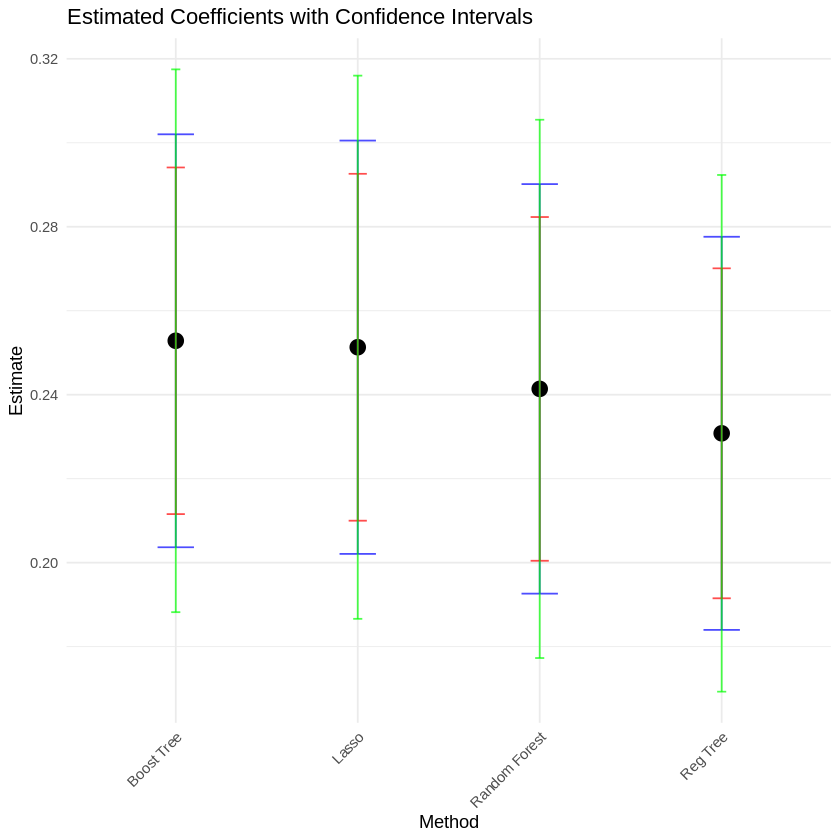

In [ ]:
table_ci<-as.data.frame(table)
table_ci$CI_Lower_1 <- table_ci$Estimate - 2.576 * table_ci$'Standard Error'
table_ci$CI_Upper_1 <- table_ci$Estimate + 2.576 * table_ci$'Standard Error'
table_ci$CI_Lower_5 <- table_ci$Estimate - 1.96 * table_ci$'Standard Error'
table_ci$CI_Upper_5 <- table_ci$Estimate + 1.96 * table_ci$'Standard Error'
table_ci$CI_Lower_10 <- table_ci$Estimate - 1.645 * table_ci$'Standard Error'
table_ci$CI_Upper_10 <- table_ci$Estimate + 1.645 * table_ci$'Standard Error'

ggplot(table_ci, aes(x = rownames(table_ci), y = Estimate)) +
  geom_point(size = 4) +
  geom_errorbar(aes(ymin = CI_Lower_5, ymax = CI_Upper_5), width = 0.2, color = "blue", alpha = 0.7) +
  geom_errorbar(aes(ymin = CI_Lower_10, ymax = CI_Upper_10), width = 0.1, color = "red", alpha = 0.7) +
  geom_errorbar(aes(ymin = CI_Lower_1, ymax = CI_Upper_1), width = 0.05, color = "green", alpha = 0.7) +
  labs(title = "Estimated Coefficients with Confidence Intervals",
       y = "Estimate",
       x = "Method") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

#### 3.6. Model

To choose the best model, we must compare the RMSEs of the outcome variable Y. In this case, the model with the lowest RMSE for Y 
is generated by Lasso (0.4716420), whereas the lowest for the treatment is generated by Boosting Trees (0.4983734). Therefore, DML 
could be employed with Y cleaned using Lasso and the treatment using Boosting Trees.